# Подготовка и анализ данных

In [1]:
import numpy as np
import pandas as pd
import pickle
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#%matplotlib inline
import seaborn as sns

import torch
import transformers as ppb

from scipy.sparse import csr_matrix, hstack

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
times = ['time'+str(i) for i in range(1,11)]
times

['time1',
 'time2',
 'time3',
 'time4',
 'time5',
 'time6',
 'time7',
 'time8',
 'time9',
 'time10']

In [3]:
# Read the training and test data sets and parse dates
train_df = pd.read_csv('train.csv',
                       index_col='session_id', parse_dates=times)

test_df = pd.read_csv('test.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

train_df_cv = train_df.copy()
test_df_cv = test_df.copy()

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 21669 to 204762
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  

The training data set contains the following features:

- **site1** – ID of the first visited website in the session
- **time1** – visiting time for the first website in the session
- ...
- **site10** – ID of the tenth visited website in the session
- **time10** – visiting time for the tenth website in the session
- **target** – target variable, equals 1 for Alice's sessions, and 0 otherwise

In [5]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site'+str(i) for i in range(1, 11)]
train_df_cv[sites] = train_df_cv[sites].fillna(0).astype('int')
test_df_cv[sites] = test_df_cv[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)
    
# r before a string means "raw", i.e. take the string as it comes,
# e.g. as a file path without interpreting special symbols like \n

print('Websites total:', len(site_dict))

Websites total: 48371


In [6]:
# See what's in the dict
list(site_dict.items())[:3]

[('www.abmecatronique.com', 25075),
 ('groups.live.com', 13997),
 ('majeureliguefootball.wordpress.com', 42436)]

In [7]:
# Size of the sets
print(test_df.shape, train_df.shape)

(82797, 20) (253561, 21)


In [8]:
# What's inside the train
train_df_cv.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


## Создание признаков через CountVectorizer

Работаем только с сайтами (пока)

In [9]:
cv = CountVectorizer(ngram_range=(1, 5), max_features=150000)

ngram_range=(1, 5) лучше, чем ngram_range=(1, 10). CountVectorizer лучше TfidfVectorizer

Создаем файы из-за огромных размеров строк, как понимаю

In [10]:
train_df_cv[sites].fillna(0).to_csv('train_sessions_text.txt', 
                                 sep=' ', index=None, header=None)
test_df_cv[sites].fillna(0).to_csv('test_sessions_text.txt', 
                                sep=' ', index=None, header=None)

In [11]:
%%time

with open('train_sessions_text.txt') as inp_train_file:
    X_train_cv = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test_cv = cv.transform(inp_test_file)

print(X_train_cv.shape, X_test_cv.shape)

# Note very big dimensions of matrices: 253561 * 50000 = 12678050000 elements in train! Only sparse matrices can take it.

(253561, 150000) (82797, 150000)
CPU times: total: 20.4 s
Wall time: 20.4 s


## Создание временных признаков

Создадим всевозможные признаки для дальшейшего исследования

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   site1   82797 non-null  int64         
 1   time1   82797 non-null  datetime64[ns]
 2   site2   81308 non-null  float64       
 3   time2   81308 non-null  datetime64[ns]
 4   site3   80075 non-null  float64       
 5   time3   80075 non-null  datetime64[ns]
 6   site4   79182 non-null  float64       
 7   time4   79182 non-null  datetime64[ns]
 8   site5   78341 non-null  float64       
 9   time5   78341 non-null  datetime64[ns]
 10  site6   77566 non-null  float64       
 11  time6   77566 non-null  datetime64[ns]
 12  site7   76840 non-null  float64       
 13  time7   76840 non-null  datetime64[ns]
 14  site8   76151 non-null  float64       
 15  time8   76151 non-null  datetime64[ns]
 16  site9   75484 non-null  float64       
 17  time9   75484 non-null  datetime64[ns]
 18  site10

In [13]:
def time_operations(df):
    if 'target' in df.columns:
        df['number_of_sites'] = ((df.notna().sum(axis=1)) / 2) - 0.5
    else:
        df['number_of_sites'] = ((df.notna().sum(axis=1)) / 2)
    df['session_strt'] = df[[f"time{i}" for i in range(1,11)]].min(axis=1)
    df['session_end'] = df[[f"time{i}" for i in range(1,11)]].max(axis=1)
    df['session_len'] = (df['session_end'] - df['session_strt']).dt.seconds
    df['weekday'] = df['session_strt'].dt.dayofweek
    df['weekday'] = df['weekday'].astype('category')
    df['start_hour'] = df['session_strt'].dt.hour
    df['start_hour'] = df['start_hour'].astype('category')
    df['end_hour'] = df['session_end'].dt.hour
    df['end_hour'] = df['end_hour'].astype('category')
    df['day'] = df['session_strt'].dt.day
    df['day'] = df['day'].astype('category')
    df['minute'] = df['session_strt'].dt.minute
    df['month'] = df['session_strt'].dt.month
#     df = df.sort_values('session_strt', ignore_index=True)
#     df = df.reset_index()
#     df = df.rename(columns={'index':'time_index'})
#     df = df.sort_values('session_id', ignore_index=True)
    return df

In [14]:
train_df= time_operations(train_df)

In [15]:
test_df = time_operations(test_df)

In [16]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,number_of_sites,session_strt,session_end,session_len,weekday,start_hour,end_hour,day,minute,month
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,2.0,2013-01-12 08:05:57,2013-01-12 08:05:57,0,5,8,8,12,5,1
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,4.0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786,5,8,9,12,37,1
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,10.0,2013-01-12 08:50:13,2013-01-12 08:50:17,4,5,8,8,12,50,1
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,10.0,2013-01-12 08:50:17,2013-01-12 08:50:20,3,5,8,8,12,50,1
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,10.0,2013-01-12 08:50:20,2013-01-12 08:50:22,2,5,8,8,12,50,1


In [17]:
alice = train_df['target'] == 1

### Дата сессии

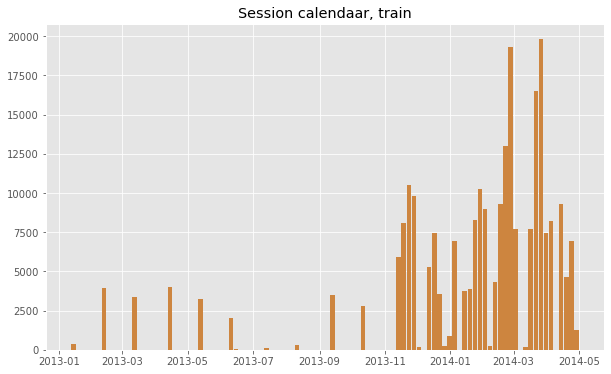

In [18]:
ax, fig = plt.subplots(figsize=(10,6))
plt.hist(train_df.session_strt, bins=100,rwidth=0.9,color='peru')

plt.title('Session calendar, train')
plt.show()

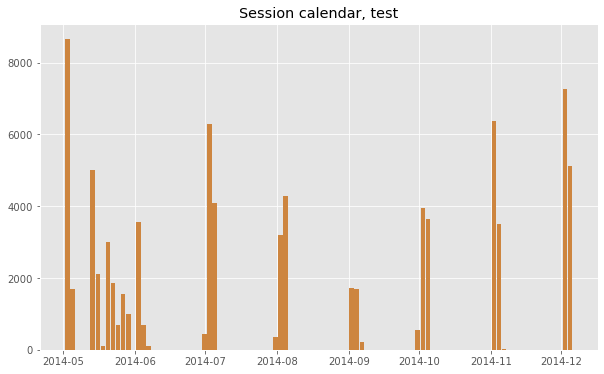

In [19]:
ax, fig = plt.subplots(figsize=(10,6))
plt.hist(test_df.session_strt, bins=100,rwidth=0.9,color='peru')

plt.title('Session calendar, test')
plt.show()

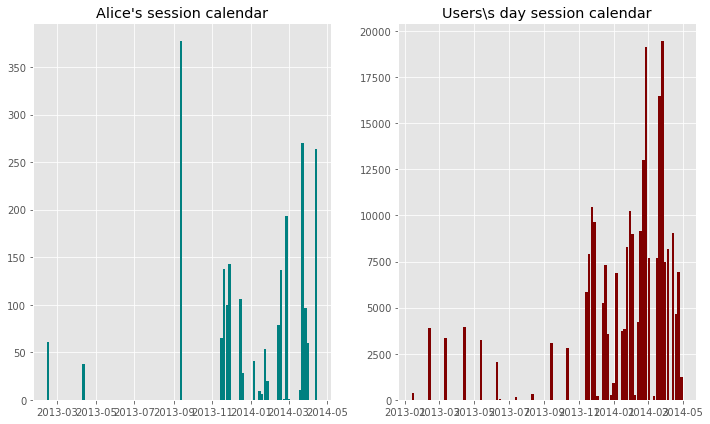

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].hist(train_df[alice].session_strt, bins=100,rwidth=0.9, color='teal', label='Alice')
ax[1].hist(train_df[~alice].session_strt, bins=100,rwidth=0.9, color='maroon', label='Users')

ax[0].title.set_text('Alice\'s session calendar')
ax[1].title.set_text('Users\s day session calendar')
plt.tight_layout()
plt.show()

### Продолжительность сессии ⚠️

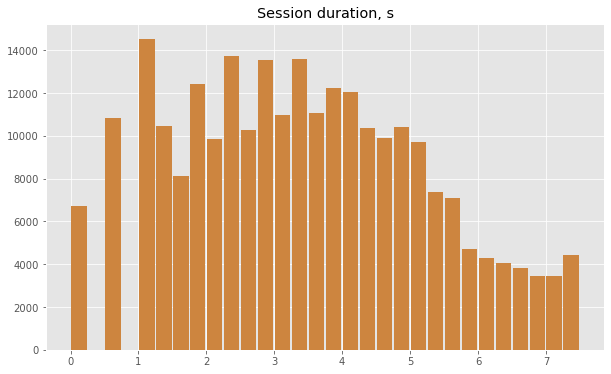

In [21]:
ax, fig = plt.subplots(figsize=(10,6))
plt.hist(np.log(train_df.session_len + 1), bins=30,rwidth=0.9,color='peru')

plt.title('Session duration, s')
plt.show()

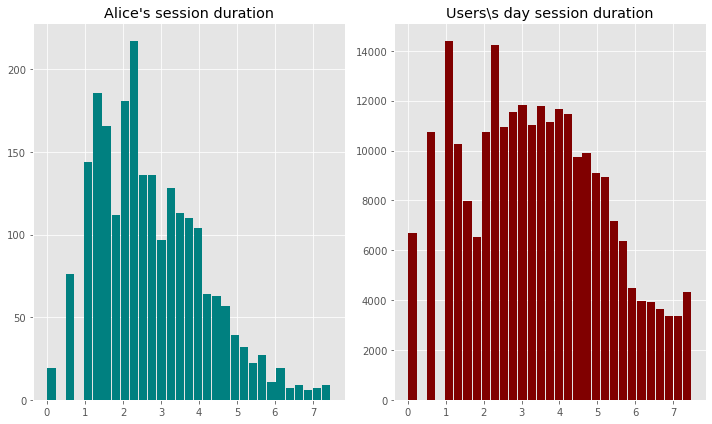

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].hist(np.log(train_df[alice].session_len + 1), bins=31,rwidth=0.9, color='teal', label='Alice')
ax[1].hist(np.log(train_df[~alice].session_len + 1), bins=31,rwidth=0.9, color='maroon', label='Users')

ax[0].title.set_text('Alice\'s session duration')
ax[1].title.set_text('Users\s day session duration')
plt.tight_layout()
plt.show()

Отличается несильно, настолько, что пришлось брать логарифм, чтобы было нагляднее. Пока можно не брать

### День недели ✔️

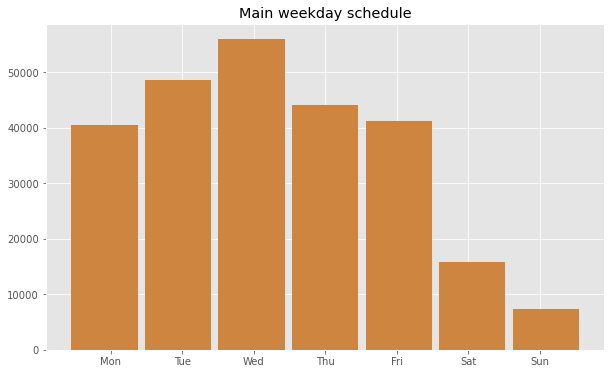

In [23]:
ax, fig = plt.subplots(figsize=(10,6))
plt.hist(train_df.weekday, bins=7,rwidth=0.9,color='peru')
plt.xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)], labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Main weekday schedule')
plt.show()

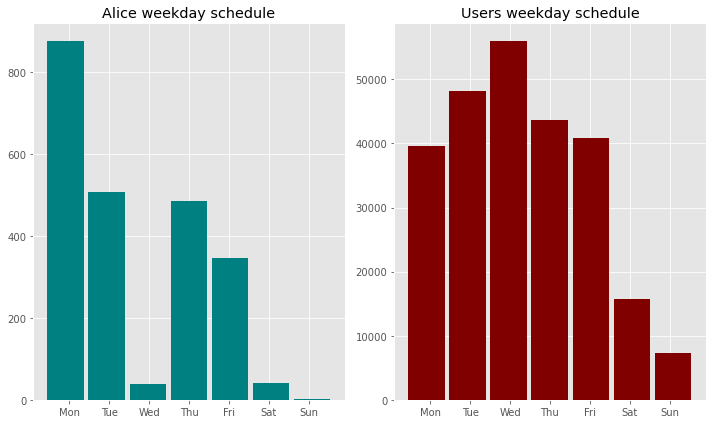

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].hist(train_df[alice].weekday, bins=7, color='teal', label='Alice', rwidth=0.9)
ax[1].hist(train_df[~alice].weekday, bins=7, color='maroon', label='Users', rwidth=0.9)
ax[0].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[1].set_xticks(ticks=[i - 0.5 for i in np.linspace(1,6,7)])
ax[0].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[1].set_xticklabels(labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax[0].title.set_text('Alice weekday schedule')
ax[1].title.set_text('Users weekday schedule')
plt.tight_layout()
plt.show()

Элис не работает по выходным, редко в среду, чаще всего в понедельник. Данные отличаются, поэтому эту фичу оставляем

### Час начала сессии ✔️

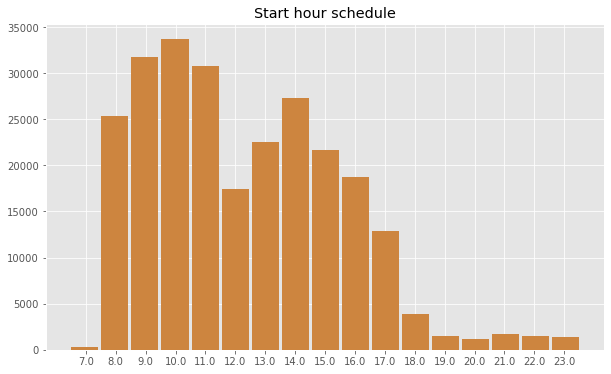

In [25]:
ax, fig = plt.subplots(figsize=(10,6))
plt.hist(train_df.start_hour, bins=17,rwidth=0.9,color='peru')
plt.xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)], labels=[i for i in np.linspace(7, 23, 17)])
plt.title('Start hour schedule')
plt.show()

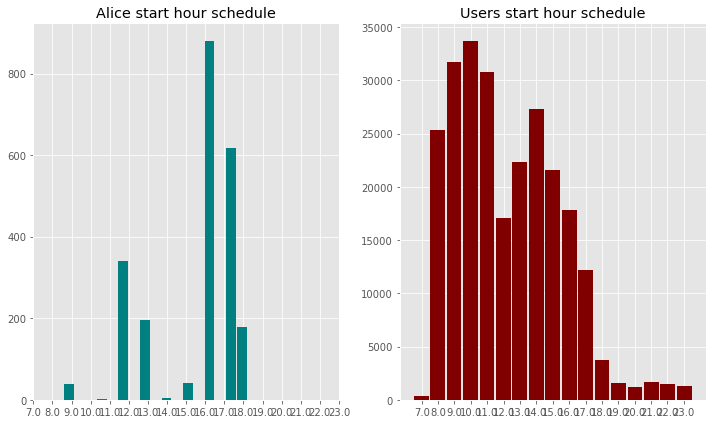

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].hist(train_df[alice].start_hour, bins=17,rwidth=0.9, color='teal', label='Alice')
ax[1].hist(train_df[~alice].start_hour, bins=17,rwidth=0.9, color='maroon', label='Users')

ax[0].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[1].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[0].set_xticklabels(labels=[i for i in np.linspace(7, 23, 17)])
ax[1].set_xticklabels(labels=[i for i in np.linspace(7, 23, 17)])

ax[0].title.set_text('Alice start hour schedule')
ax[1].title.set_text('Users start hour schedule')
plt.tight_layout()
plt.show()

Оставляем

### Час конца сессии ❌

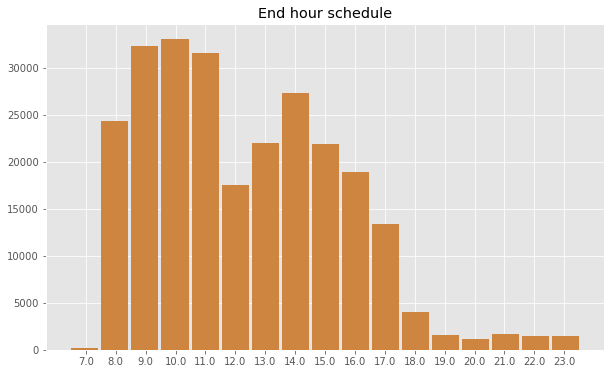

In [27]:
ax, fig = plt.subplots(figsize=(10,6))
plt.hist(train_df.end_hour, bins=17,rwidth=0.9,color='peru')
plt.xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)], labels=[i for i in np.linspace(7, 23, 17)])
plt.title('End hour schedule')
plt.show()

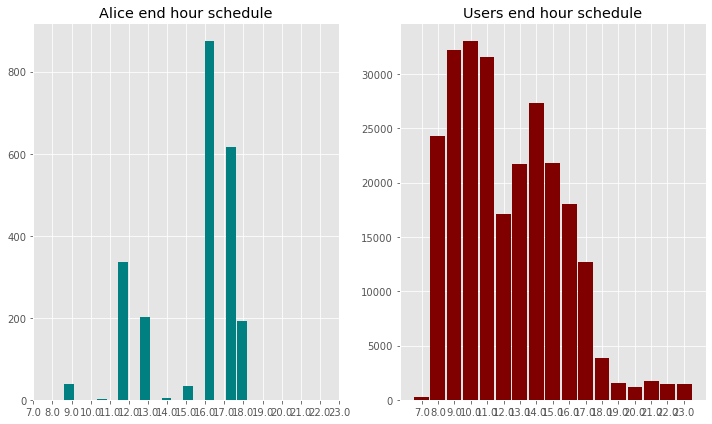

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].hist(train_df[alice].end_hour, bins=17,rwidth=0.9, color='teal', label='Alice')
ax[1].hist(train_df[~alice].end_hour, bins=17,rwidth=0.9, color='maroon', label='Users')

ax[0].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[1].set_xticks(ticks=[i + 0.5 for i in np.linspace(7,22,17)])
ax[0].set_xticklabels(labels=[i for i in np.linspace(7, 23, 17)])
ax[1].set_xticklabels(labels=[i for i in np.linspace(7, 23, 17)])

ax[0].title.set_text('Alice end hour schedule')
ax[1].title.set_text('Users end hour schedule')
plt.tight_layout()
plt.show()

Все то же самое, что и с часом начала сессии (логично, ведь сессия длится максимум полчаса). Эта фича уйдет, поскольку сильно коррелирует с часом начала сессии

### День начала сессии ✔️

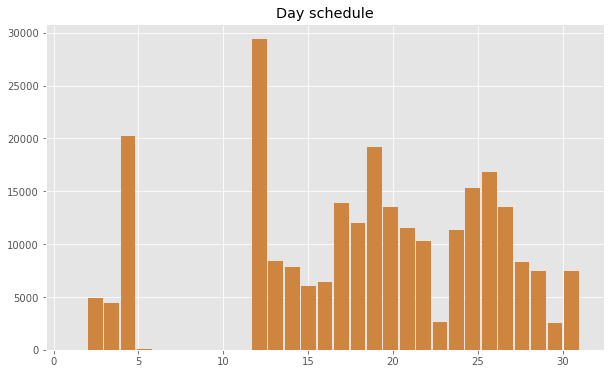

In [29]:
ax, fig = plt.subplots(figsize=(10,6))
plt.hist(train_df.day, bins=31,rwidth=0.9,color='peru')
plt.title('Day schedule')
plt.show()

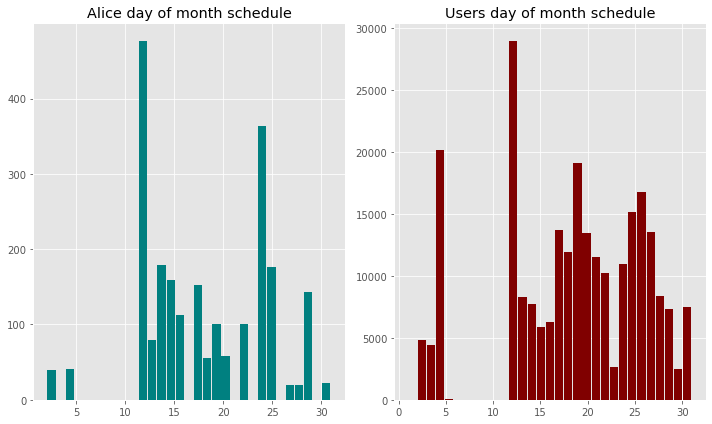

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].hist(train_df[alice].day, bins=31,rwidth=0.9, color='teal', label='Alice')
ax[1].hist(train_df[~alice].day, bins=31,rwidth=0.9, color='maroon', label='Users')

ax[0].title.set_text('Alice day of month schedule')
ax[1].title.set_text('Users day of month schedule')
plt.tight_layout()
plt.show()

Есть дни, в которых Элис неактивна совсем. Если оставить фичу в чистом виде, она снижает скор на валидации. Можно попробовать создать фичу "Происходит ли сессия в ... дни"

In [31]:
train_df["online_day"] = train_df['time1'].apply(lambda ts: ts.day in train_df[alice].day.unique()).astype(np.int8)

In [32]:
test_df["online_day"] = test_df['time1'].apply(lambda ts: ts.day in train_df[alice].day.unique()).astype(np.int8)

### Минута начала сессии ⚠️

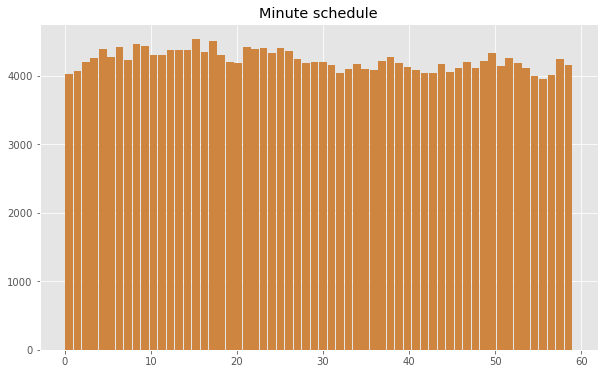

In [33]:
ax, fig = plt.subplots(figsize=(10,6))
plt.hist(train_df.minute, bins=60,rwidth=0.9,color='peru')
plt.title('Minute schedule')
plt.show()

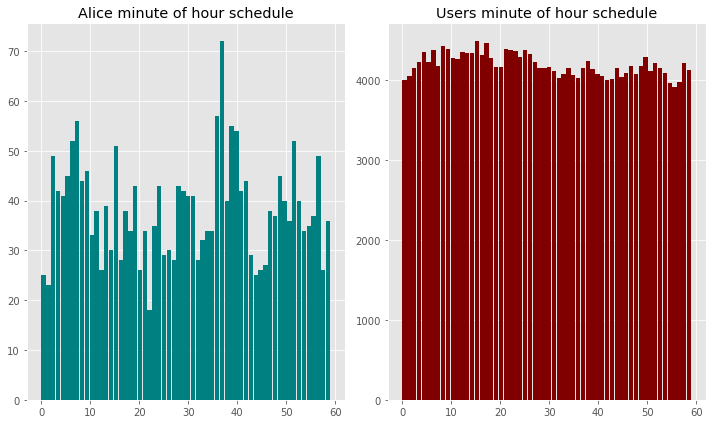

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].hist(train_df[alice].minute, bins=60,rwidth=0.9, color='teal', label='Alice')
ax[1].hist(train_df[~alice].minute, bins=60,rwidth=0.9, color='maroon', label='Users')

ax[0].title.set_text('Alice minute of hour schedule')
ax[1].title.set_text('Users minute of hour schedule')
plt.tight_layout()
plt.show()

Поведение Элис и здесь отличается, но не существенно. На валидации скор падает, поэтому эту фичу убираем

### Месяц сессии ⚠️

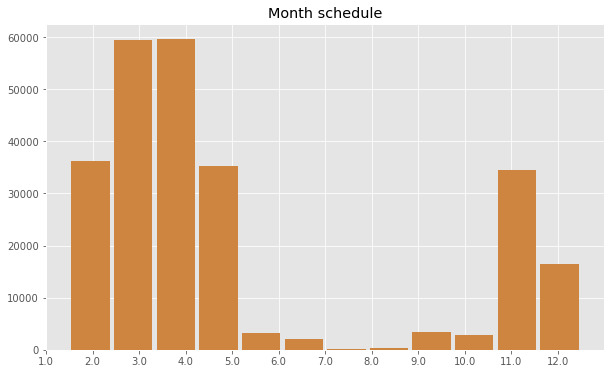

In [35]:
ax, fig = plt.subplots(figsize=(10,6))
plt.hist(train_df.month, bins=12,rwidth=0.9,color='peru')
plt.xticks(ticks=[i - 0.5 for i in np.linspace(1,12,12)], labels=[i for i in np.linspace(1,12,12)])
plt.title('Month schedule')
plt.show()

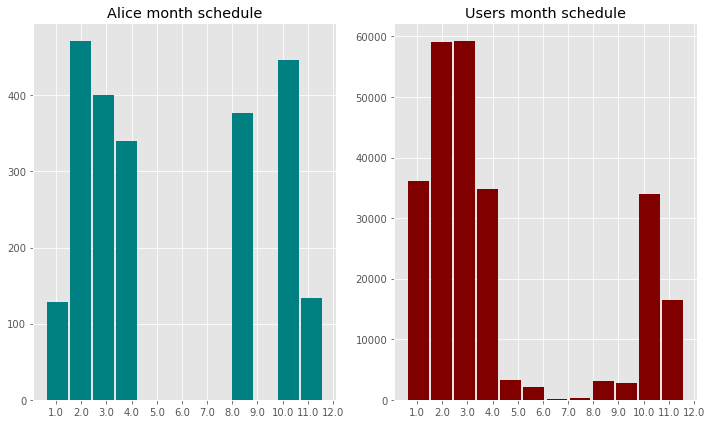

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].hist(train_df[alice].month, bins=12,rwidth=0.9, color='teal', label='Alice')
ax[1].hist(train_df[~alice].month, bins=12,rwidth=0.9, color='maroon', label='Users')

ax[0].set_xticks(ticks=[i + 0.4 for i in np.linspace(1,12,12)])
ax[1].set_xticks(ticks=[i + 0.4 for i in np.linspace(1,12,12)])
ax[0].set_xticklabels(labels=[i for i in np.linspace(1,12,12)])
ax[1].set_xticklabels(labels=[i for i in np.linspace(1,12,12)])

ax[0].title.set_text('Alice month schedule')
ax[1].title.set_text('Users month schedule')
plt.tight_layout()
plt.show()

Отличия небольшие, возможно потом уберем

## Создаем dummy-переменные

In [37]:
def get_dummies(train_df):
    col_names = ['weekday','start_hour'] #, 'minute'] #, 'day']
    train_df = train_df[col_names]
    train_df_time = pd.get_dummies(train_df, columns=col_names,
                           drop_first=True)
    train_df_time = train_df_time.dropna()
    return train_df_time

In [38]:
train_df_time  = get_dummies(train_df)
test_df_time = get_dummies(test_df)

## Склеиваем признаки

In [39]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    return hstack([X, csr_matrix(feature_to_add)], 'csr')

In [40]:
# X_train = add_feature(X_train_cv, train_df_time)
# X_test = add_feature(X_test_cv, test_df_time)

In [41]:
X_train_pre = add_feature(X_train_cv, train_df_time)
X_test_pre = add_feature(X_test_cv, test_df_time)

X_train = add_feature(X_train_pre, train_df[['online_day']])
X_test = add_feature(X_test_pre, test_df[['online_day']])

# Model Training

In [42]:
def get_auc_lr_valid(X, y, C=1, seed=17, ratio = 0.9):
    
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    
    # Classifier training
    lr = LogisticRegression(C=0.5994842503189409, random_state=seed,
                            multi_class='auto', penalty='l1', solver='liblinear', max_iter=1000).fit(X[:idx, :], y[:idx])
#     # Classifier training
#     lr = LogisticRegression(C=C, random_state=seed, solver='lbfgs', max_iter=1000).fit(X[:idx, :], y[:idx])

    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [43]:
# Our target variable
y_train = train_df_cv['target'].values

Подбираем параметры для логистической регрессии

In [44]:
%%time
# Calculate metric on the validation set. 90% of train data for training. 10% for validation.

print(get_auc_lr_valid(X_train, y_train))

0.9778036522566652
CPU times: total: 25.2 s
Wall time: 25.2 s


## Подбираем параметры

In [45]:
# tss = TimeSeriesSplit(n_splits=10)



# from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

# def objective(search_space):
#     model = LogisticRegression(C=search_space['C'], solver=search_space['solver'],
#                                multi_class=search_space['multi_class'], penalty=search_space['penalty'],
#                                random_state=17, max_iter=500, n_jobs=-1)
#     roc_auc = cross_val_score(model, X_train, y_train, cv=tss, scoring='roc_auc').mean()
#     return {'loss': roc_auc, 'status': STATUS_OK}

# search_space = {
#                  'C':np.logspace(-2, 2, 10),  # задаем возможные параметры для С
#                 'solver':hp.choice['lbfgs', 'liblinear'],  # задаем возможные параметры для солвера
#                 'multi_class':hp.choice['auto', 'ovr'],
#                 'penalty':hp.choice['l1', 'l2', 'elasticnet', 'none']
#                 }

# algorithm=tpe.suggest  # использовать Tree of Parzen Estimators

# best_params = fmin(
#   fn=objective,
#   space=search_space,
#   algo=algorithm,
#   max_evals=25
# )

# space_eval(search_space, best_params)

In [46]:
lr = LogisticRegression(C=1, random_state=17,
                            multi_class='ovr', penalty='l1', solver='liblinear', max_iter=1000)
tss = TimeSeriesSplit(n_splits=10)

c_params = np.logspace(-2, 2, 10)  # задаем возможные параметры для С
solver_params = ['lbfgs', 'liblinear']  # задаем возможные параметры для солвера

gs_model = GridSearchCV(estimator=lr, 
                                   param_grid={'C': c_params, 'solver':solver_params},
                                   scoring='roc_auc', 
                                   n_jobs=-1, 
                                   cv=tss, 
                                   verbose=1)

In [47]:
# %%time
# gs_model.fit(X_train, y_train)

In [48]:
# gs_model.best_score_, gs_model.best_params_

# (0.9397987760651763, {'C': 0.5994842503189409, 'solver': 'liblinear'})

## Выводим результат

In [49]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = range(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [50]:
# Train the model on the whole training data set
# Use random_state=17 for reproducibility
# Parameter C=1 by default, but here we set it explicitly

lr = LogisticRegression(C=1, random_state=17, multi_class='ovr', penalty='l1', solver='liblinear',
                        max_iter=1000).fit(X_train, y_train)

# Make a prediction for test data set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

В итоге при C=1 наивысший скор